In [12]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [13]:
# -------------------------------
# Define the system dynamics
# -------------------------------

def fcn_invpend_spring_ode(t, x, M):
    """
    Continuous nonlinear dynamics (used for simulation).
    """
    # Parameters
    g = 9.81
    l = 4
    d = 3.5
    m = 0.15
    k = 0.3
    c = 0.05

    theta = x[0]
    omega = x[1]
    dtheta = omega
    domega = -(k * d**2 / (m * l**2)) * np.sin(theta) * np.cos(theta) \
             - (c / (m * l**2)) * d**2 * (np.cos(theta)**2) * omega \
             + (g / l) * np.sin(theta) + (M / (m * l**2))
    # Return as a NumPy array to ensure consistent type
    return np.array([dtheta, domega])

def fcn_invpend_spring_ode_rhs(x, M):
    """
    ODE right-hand side used in the MPC model (with a slight simplification).
    This function is built with CasADi symbolic operations.
    """
    # Parameters
    g = 9.81
    l = 4
    d = 3.5
    m = 0.15
    k = 0.3
    c = 0.05

    # In the MPC model we approximate sin(theta) with theta
    dtheta = x[1]
    domega = -(k * d**2 / (m * l**2)) * x[0] \
             - (c / (m * l**2)) * d**2 * (ca.cos(x[0])**2) * x[1] \
             + (g / l) * x[0] + (M / (m * l**2))
    return ca.vertcat(dtheta, domega)

def runge_kutta_4(func, dT, x, u):
    """
    Fourth-order Runge-Kutta integration (using CasADi symbolic expressions).
    """
    k1 = func(x, u)
    k2 = func(x + dT/2 * k1, u)
    k3 = func(x + dT/2 * k2, u)
    k4 = func(x + dT * k3, u)
    return x + dT/6 * (k1 + 2*k2 + 2*k3 + k4)

In [14]:
# -------------------------------
# Main MPC simulation
# -------------------------------


# MPC parameters
ctrldT = 0.1           # MPC time step (seconds)
mpc_horizon = 5        # Number of intervals in the horizon
nctrl = 1              # Number of control inputs
nstates = 2            # Number of states

Q_x = 1000 * np.eye(nstates)   # State cost weighting matrix
R_u = 0.1 * np.eye(nctrl)      # Control cost weighting matrix

# Control constraints
umin = -2 * np.ones((nctrl, 1))
umax = 2 * np.ones((nctrl, 1))
# State constraints: first state (theta) is limited to ±40° (in radians)
theta_min = -np.deg2rad(40)
theta_max = np.deg2rad(40)

# -------------------------------
# Construct the NLP using multiple shooting
# -------------------------------

# Symbolic variables for state and control trajectories
X = ca.SX.sym('X', nstates, mpc_horizon+1)
U = ca.SX.sym('U', nctrl, mpc_horizon)

# Parameter vector P: current state, desired state trajectory, and desired control trajectory
P_dim = nstates + (mpc_horizon+1)*nstates + mpc_horizon*nctrl
P = ca.SX.sym('P', P_dim)

obj = 0  # Objective function
g = []   # Constraints vector

# Initial condition constraint: X[:,0] - x_now = 0
g.append(X[:, 0] - P[0:nstates])

# Use the ODE (with approximation) for the prediction model
odef = fcn_invpend_spring_ode_rhs

# Loop over the prediction horizon
for k in range(mpc_horizon):
    xk = X[:, k]
    uk = U[:, k]
    # Desired state at stage k (from parameter vector P)
    target = P[nstates + k*nstates : nstates + (k+1)*nstates]
    # Stage cost: state error and control effort
    obj = obj + ca.mtimes([(xk - target).T, Q_x, (xk - target)]) \
              + ca.mtimes([uk.T, R_u, uk])
    # Integrate dynamics using RK4
    xk_next = runge_kutta_4(odef, ctrldT, xk, uk)
    # Continuity constraint: X[:, k+1] - xk_next = 0
    g.append(X[:, k+1] - xk_next)

g = ca.vertcat(*g)
# Decision variable: vectorized form of states and controls
W = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))

# Create the NLP problem structure
nlp_prob = {'f': obj, 'x': W, 'g': g, 'p': P}

# Solver options
opts = {
    'ipopt.max_iter': 4000,
    'ipopt.print_level': 0,
    'print_time': 0,
    'ipopt.acceptable_tol': 1e-8,
    'ipopt.acceptable_obj_change_tol': 1e-6,
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

# -------------------------------
# Set bounds for constraints and decision variables
# -------------------------------

# Equality constraints (g == 0)
lbg = np.zeros(g.shape)
ubg = np.zeros(g.shape)

# Decision variable dimensions
nX = (mpc_horizon+1) * nstates
nU = mpc_horizon * nctrl
W_dim = nX + nU

# Initialize decision variable bounds as unbounded
lbx = -ca.inf * np.ones(W_dim)
ubx = ca.inf * np.ones(W_dim)

# Impose state bounds for theta (first state of each state vector)
for i in range(mpc_horizon+1):
    idx = i * nstates   # theta index (0-indexed)
    lbx[idx] = theta_min
    ubx[idx] = theta_max
    # omega remains unconstrained

# Impose control bounds for all control variables (second part of W)
for i in range(nU):
    lbx[nX + i] = -2
    ubx[nX + i] = 2

lbx = np.array(lbx).flatten()
ubx = np.array(ubx).flatten()

/tmp/ipykernel_6703/2405859758.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_opt = float(Upred[:, 0])


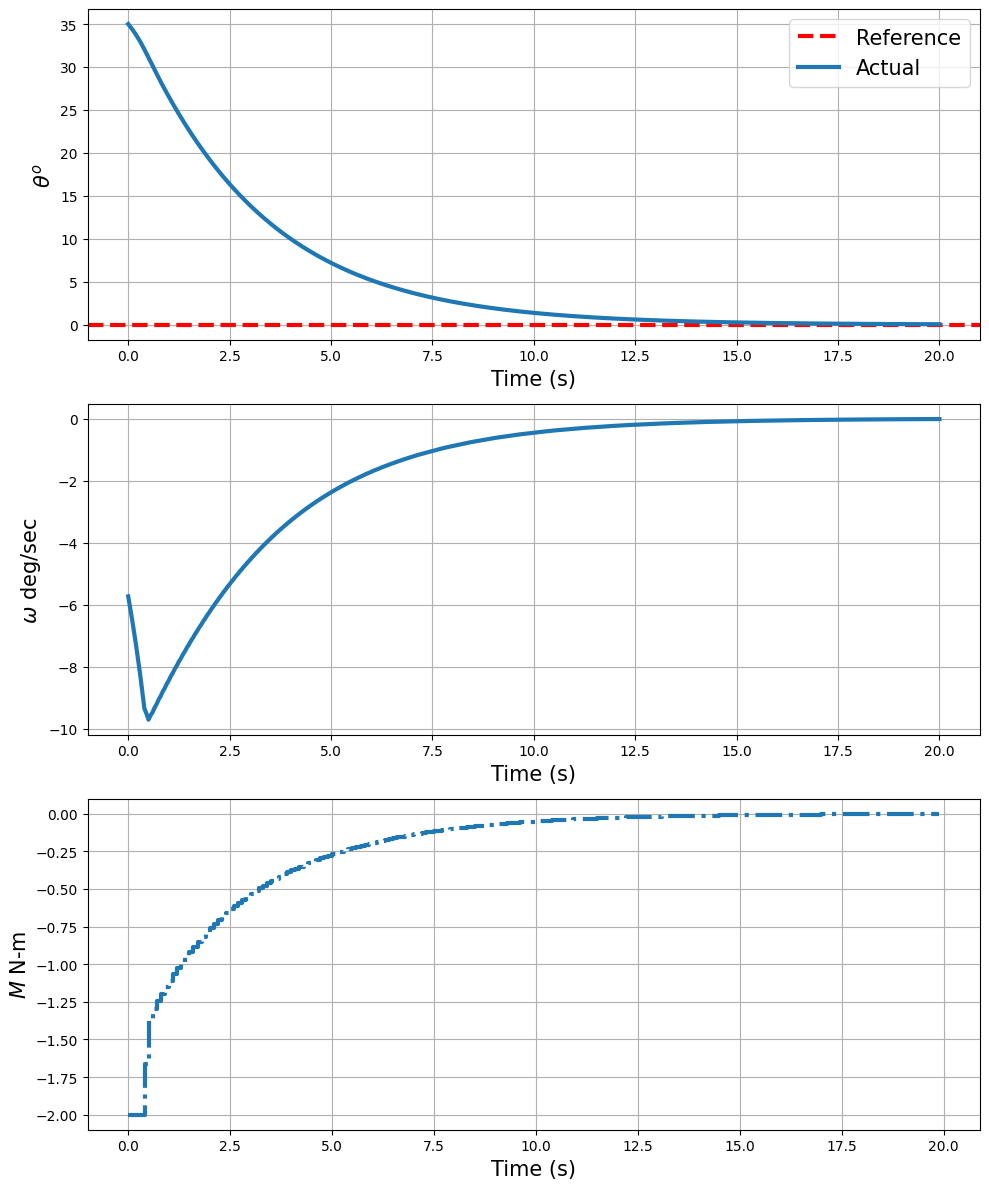

In [15]:

# -------------------------------
# Simulation settings
# -------------------------------

tsim_sim = 20                           # Total simulation time (seconds)
tspan_sim = np.arange(0, tsim_sim+ctrldT, ctrldT)  # Sampling times with 0.1 s interval
N_sim = len(tspan_sim) - 1
dt_sim = 0.05                           # Integration time step (for continuous simulation)

# Initial condition for the system
x0 = np.array([np.deg2rad(35), -0.1])

# Desired state trajectory (zeros) and control (zeros) over the horizon
xd = np.zeros(((mpc_horizon+1)*nstates, 1))
ud = np.zeros((mpc_horizon*nctrl, 1))

# Storage for results
X_mpc = x0.reshape(-1, 1)  # States at sampling instants
u_mpc = []                # Applied control inputs
X_act = []                # Continuous simulation trajectories
t_all = []                # Simulation time stamps

# Initial guess for the optimization (states and controls)
Xinit = np.tile(x0.reshape(-1, 1), (1, mpc_horizon+1))
Uinit = np.zeros((nctrl, mpc_horizon))

# -------------------------------
# Main simulation loop (MPC)
# -------------------------------

for k in range(N_sim):
    x_now = X_mpc[:, -1]
    # Construct the parameter vector: [current state; desired state trajectory; desired control trajectory]
    p_val = np.concatenate([x_now, xd.flatten(), ud.flatten()])
    # Initial guess for decision variables W (using column-major flattening to mimic MATLAB)
    W0 = np.concatenate([Xinit.flatten('F'), Uinit.flatten('F')])
    
    # Solve the NLP
    sol = solver(x0=W0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=p_val)
    sol_x = sol['x'].full().flatten()
    
    # Extract predicted state and control trajectories
    Xpred = sol_x[:nX]
    Upred = sol_x[nX:]
    Xpred = Xpred.reshape((nstates, mpc_horizon+1), order='F')
    Upred = Upred.reshape((nctrl, mpc_horizon), order='F')
    
    # Shift predicted trajectories for the next iteration
    Uinit = np.hstack([Upred[:, 1:], Upred[:, -1:]])
    Xinit = np.hstack([Xpred[:, 1:], Xpred[:, -1:]])
    
    # The optimal control to apply at the current step (convert to scalar)
    u_opt = float(Upred[:, 0])
    u_mpc.append(u_opt)
    
    # Simulate the continuous-time system over the current sampling interval using solve_ivp.
    # Use np.linspace to ensure t_eval is within [t_current, t_next]
    t_current = tspan_sim[k]
    t_next = tspan_sim[k+1]
    num_steps = int(np.round((t_next - t_current) / dt_sim)) + 1
    t_eval = np.linspace(t_current, t_next, num_steps)
    
    sol_ivp = solve_ivp(lambda t, x: fcn_invpend_spring_ode(t, x, u_opt),
                        [t_current, t_next], x_now, t_eval=t_eval)
    # Get the state at the end of the sampling period
    x_next = sol_ivp.y[:, -1]
    X_mpc = np.hstack([X_mpc, x_next.reshape(-1, 1)])
    # Store the continuous trajectory and time
    X_act.append(sol_ivp.y.T)
    t_all.append(sol_ivp.t)

# Concatenate stored trajectories for plotting
X_act = np.vstack(X_act)
t_all = np.concatenate(t_all)

# Save the continuous trajectory (e.g., as a NumPy file)
#np.save('X_pend.npy', X_act)

# -------------------------------
# Plotting results
# -------------------------------

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot theta (in degrees) vs. time with a reference line at 0
axs[0].axhline(0, color='r', linestyle='--', linewidth=3, label='Reference')
axs[0].plot(t_all, np.rad2deg(X_act[:, 0]), linewidth=3, label='Actual')
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel(r'$\theta^o$', fontsize=15)
axs[0].legend(fontsize=15)
axs[0].grid(True)

# Plot omega (converted to deg/sec)
axs[1].plot(t_all, np.rad2deg(X_act[:, 1]), linewidth=3)
axs[1].set_xlabel('Time (s)', fontsize=15)
axs[1].set_ylabel(r'$\omega$ deg/sec', fontsize=15)
axs[1].grid(True)

# Plot control input as a step (stairs) plot
u_mpc = np.array(u_mpc).flatten()
t_stairs = tspan_sim[:-1]
axs[2].step(t_stairs, u_mpc, where='post', linewidth=3, linestyle='-.')
axs[2].set_xlabel('Time (s)', fontsize=15)
axs[2].set_ylabel(r'$M$ N-m', fontsize=15)
axs[2].grid(True)

plt.tight_layout()
plt.show()

